In [3]:
from __future__ import division
from matplotlib import rcParams, pyplot as plt
from cvxopt import matrix, solvers
from scipy import linalg as la
from sklearn import datasets
from scipy.stats import mode
from math import tanh, exp
import pandas as pd
import numpy as np

%matplotlib inline
rcParams["figure.figsize"] = (18,8)
solvers.options["show_progress"] = False

## K-Nearest Neighbors

### Problems 1,2,3

In [2]:
class KNN(object):
    def __init__(self, data, labels, k):
        self.data, self.labels, self.k = data, np.array(labels), k
    
    @staticmethod
    def metric(x, y):
        return la.norm(x - y, ord=2)
    
    def classify(self, point, add=False):
    
        distances = {self.metric(x, point):i for i,x in enumerate(self.data)}
        indices = np.array([distances[i] for i in sorted(distances.keys())[:self.k]])

        if self.k != len(indices):
            raise ValueError("k-neighborhood does not have k entries (k={})".format(self.k))
        
        return mode(self.labels[indices])[0][0]
    
    def accuracy(self, points, labels):
        return 100*np.mean(np.array([self.classify(point) for point in points]) == np.array(labels))

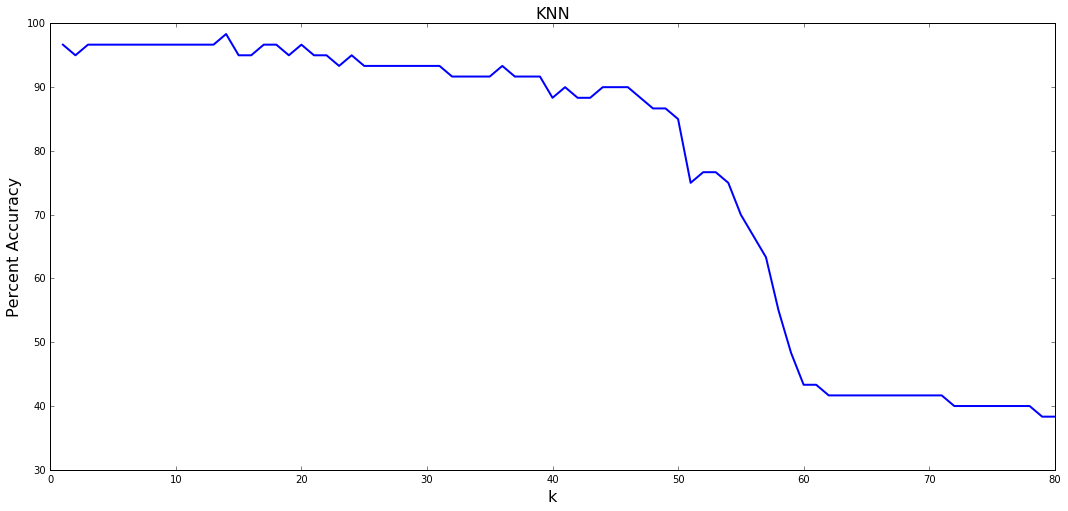

Average Percent Accuracy: 76.6666666667%


In [3]:
# Load the iris data set.
iris = datasets.load_iris()
n = len(iris["target"])

# Separate the data into training and testing sets.
index = np.arange(n)
test_index = sorted(np.random.choice(index, int(n*.4), replace=False))
train_index = [i for i in index if i not in test_index]

train_data = iris["data"][train_index]
train_labels = iris["target"][train_index]

test_data = iris["data"][test_index]
test_labels = iris["target"][test_index]

k_range = range(1,81)
accuracies = []
for k in k_range:
    knn = KNN(train_data, train_labels, k)
    accuracies.append(knn.accuracy(test_data, test_labels))

plt.plot(k_range, accuracies, linewidth=2)
plt.xlabel("k", fontsize=16)
plt.ylabel("Percent Accuracy", fontsize=16)
plt.title("KNN", fontsize=16)
plt.show()

print "Average Percent Accuracy: {}%".format(np.mean(accuracies))

## Support Vector Machines

In [4]:
class SVM(object):
        
    def setKernel(self, kind, a=0, d=2, gam=.5, r=0):
        if kind == "poly":
            self.kernel = lambda x, y: (np.dot(x,y) + a)**d
        elif kind == "RBF":
            self.kernel = lambda x, y: exp(-gam*la.norm(x-y)**2)
        elif kind == "sigmoid":
            self.kernel = lambda x, y: tanh(np.dot(x,y) + r)
        else:
            raise ValueError("Invalid option")
    
    def fit(self, data, labels):
        if not hasattr(self, "kernel"):
            raise ValueError("Please set the kernel")
        
        n = data.shape[0]

        K = np.array([[self.kernel(data[i], data[j]) for j in xrange(n)] for i in xrange(n)])
        P = matrix(np.outer(labels, labels)*K)
        q = matrix(np.ones(n)*-1)
        A = matrix(labels, (1, n))
        b = matrix(0.0)
        G = matrix(np.diag(np.ones(n)*-1))
        h = matrix(np.zeros(n))

        sol = solvers.qp(P, q, G, h, A, b)
        self.a = np.ravel(sol['x'])
        
        self.data, self.labels = np.array(data), np.array(labels)
    
    def predict(self, sample):
        f = np.dot(self.labels * self.a, np.array([self.kernel(sample, x) for x in self.data]))
        return 1 if f > 0 else -1
    
    def accuracy(self, data, labels):
        return 100*np.mean(np.array([self.predict(d) for d in data]) == np.array(labels))

#### Problem 5

In [5]:
cancer = pd.read_csv("cancer.csv", index_col=0)
cancer = cancer.loc[cancer["bare-nuclei"] != "?"]

def cancer_data():

    test = np.random.choice(cancer.index, int(.4*len(cancer.index)), replace=False)
    train = [i for i in cancer.index if i not in test]

    train_data = np.array(cancer.loc[train].drop("cancerous", axis=1), dtype=np.float)
    train_labels = np.array(cancer.loc[train]["cancerous"], dtype=np.float)

    test_data = np.array(cancer.loc[test].drop("cancerous", axis=1), dtype=np.float)
    test_labels = np.array(cancer.loc[test]["cancerous"], dtype=np.float)
    
    return train_data, train_labels, test_data, test_labels

In [6]:
svm = SVM()
train_data, train_labels, test_data, test_labels = cancer_data()
for kind in ["poly", "RBF", "sigmoid"]:
    svm.setKernel(kind)
    svm.fit(train_data, train_labels)
    PA = svm.accuracy(test_data, test_labels)
    print "Kernel Method: {}\tPercent Accuracy: {}%".format(kind, PA)

Kernel Method: poly	Percent Accuracy: 56.25%
Kernel Method: RBF	Percent Accuracy: 97.0238095238%
Terminated (singular KKT matrix).
Kernel Method: sigmoid	Percent Accuracy: 33.0357142857%


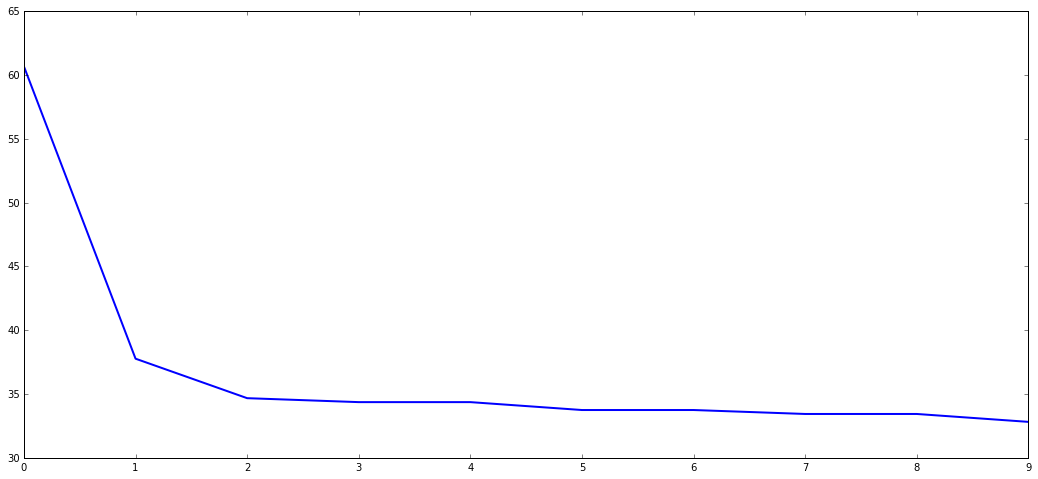

In [7]:
svm = SVM()
train_data, train_labels, test_data, test_labels = cancer_data()
a_range = np.arange(10)
PAs = []
for a in a_range:
    svm.setKernel("poly", a=a)
    svm.fit(train_data, train_labels)
    PAs.append(svm.accuracy(test_data, test_labels))

plt.plot(a_range, PAs, linewidth=2)
plt.show()

Terminated (singular KKT matrix).
Terminated (singular KKT matrix).


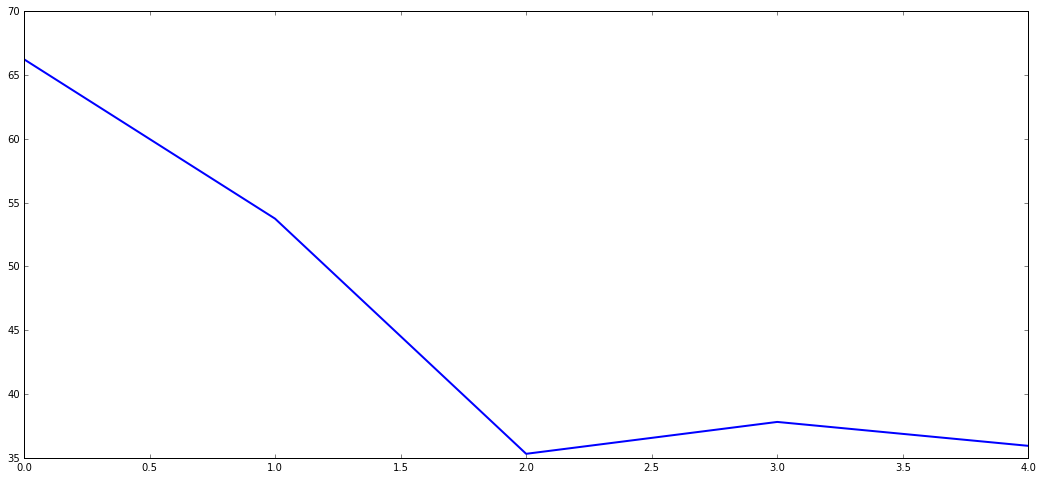

In [8]:
svm = SVM()
train_data, train_labels, test_data, test_labels = cancer_data()
d_range = np.arange(5)
PAs = []
for d in d_range:
    svm.setKernel("poly", a=0, d=d)
    svm.fit(train_data, train_labels)
    PAs.append(svm.accuracy(test_data, test_labels))

plt.plot(d_range, PAs, linewidth=2)

plt.show()

Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).


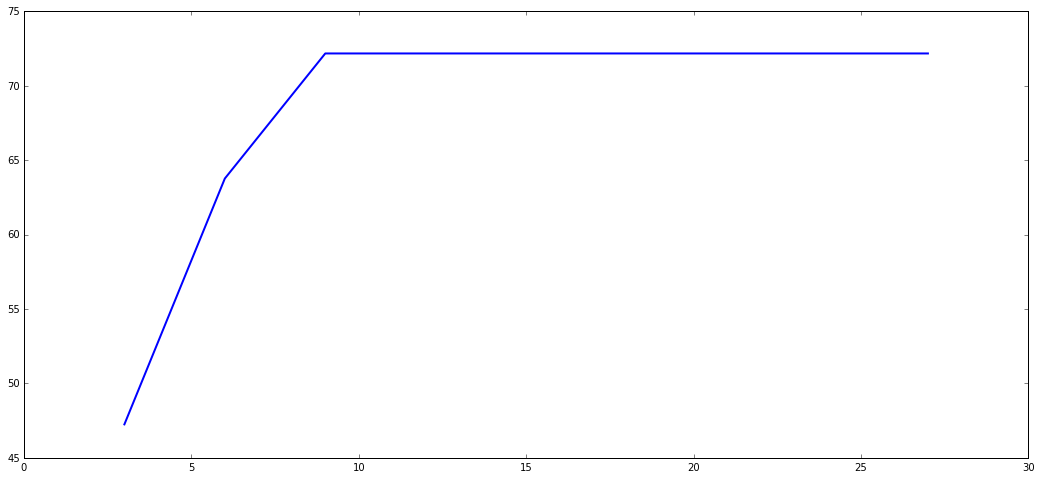

In [9]:
svm = SVM()
train_data, train_labels, test_data, test_labels = cancer_data()
r_range = np.arange(3,30,3)
PAs = []
for r in r_range:
    svm.setKernel("sigmoid", r=r)
    svm.fit(train_data, train_labels)
    PAs.append(svm.accuracy(test_data, test_labels))

plt.plot(r_range, PAs, linewidth=2)

plt.show()

In [14]:
svm = SVM()
train_data, train_labels, test_data, test_labels = cancer_data()
svm.setKernel("poly", a=0, d=1)
svm.fit(train_data, train_labels)
print svm.accuracy(test_data, test_labels)

svm.setKernel("RBF")
svm.fit(train_data, train_labels)
print svm.accuracy(test_data, test_labels)

svm.setKernel("sigmoid", r=10)
svm.fit(train_data, train_labels)
print svm.accuracy(test_data, test_labels)

Terminated (singular KKT matrix).
69.6594427245
95.0464396285
Terminated (singular KKT matrix).
69.9690402477
